# Step-by-Step Tutorial From EDA To Preprocessing for Image Detection

Thanks for nice reference : [SIIM-FISABIO-RSNA_COVID-19_Detection_Starter, DrCapa]('https://www.kaggle.com/drcapa/siim-fisabio-rsna-covid-19-detection-starter')

```
Step 1. Import Libraries
Step 2. Load Data
Step 3. Read DCM File
     3-a. explore path with python code
     3-b. make image extractor(function)
Step 4. Show Sample Image
     4-a. explore image data with python code
     4-b. check position to draw box
Step 5. Show Multiple Images
Step 6. Feature Engineering
     6-a. count opacity
     6-b. simplify 'id'
     6-c. rename colume 'id' to 'StudyInstanceUID for merge on 'StudyInstanceUID'
     6-d. check the relation between 'OpacityCount' and other columes in train_study
     6-e. visualize the relation between 'OpacityCount' and other columes in train_study
     6-f. check duplicate values(One row and Two Appearances)
```  

## Step 1. Import Libraries

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))


In [2]:
import matplotlib.pyplot as plt
import matplotlib
import pydicom as dicom
import cv2
import ast
import warnings
warnings.filterwarnings('ignore')

## Step 2. Load Data

In [3]:
path = '/kaggle/input/siim-covid19-detection/'

In [4]:
os.listdir(path)

['sample_submission.csv',
 'train_image_level.csv',
 'test',
 'train',
 'train_study_level.csv']

In [5]:
train_image = pd.read_csv(path+'train_image_level.csv')
train_study = pd.read_csv(path+'train_study_level.csv')
sample_submission = pd.read_csv(path+'sample_submission.csv')

In [6]:
len(sample_submission)

2477

In [7]:
train_image

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e
...,...,...,...,...
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06
6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d


In [8]:
train_study

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1
...,...,...,...,...,...
6049,ffcb4630f46f_study,0,1,0,0
6050,ffe4d6e8fbb0_study,0,1,0,0
6051,ffe94fcb14fa_study,0,1,0,0
6052,ffebf1ef4a9c_study,0,1,0,0


## Step 3. Read DCM File

### 3-a. explore path with python code

In [9]:
temp = train_image.loc[0, 'StudyInstanceUID']
temp

'5776db0cec75'

In [10]:
temp_depth2 = os.listdir(path+'train/'+temp)
temp_depth2[0]

'81456c9c5423'

In [11]:
temp_train_path = path+'train/'+temp+'/'+temp_depth2[0]
temp_train_path

'/kaggle/input/siim-covid19-detection/train/5776db0cec75/81456c9c5423'

In [12]:
os.listdir('/kaggle/input/siim-covid19-detection/train/5776db0cec75/81456c9c5423')  

['000a312787f2.dcm']

In [13]:
train_image.loc[0, 'id']

'000a312787f2_image'

### 3-b. make image extractor(function)

In [14]:
def extraction(i):
    path_train = path + 'train/' + train_image.loc[i, 'StudyInstanceUID']
    last_folder_in_path = os.listdir(path_train)[0]
    path_train = path_train + '/{}/'.format(last_folder_in_path)
    img_id = train_image.loc[i, 'id'].replace('_image','.dcm')
    data_file = dicom.dcmread(path_train+img_id)
    img = data_file.pixel_array
    return img

## Step 4. Show Sample Image

### 4-a. Explore Image Data with python code

In [15]:
sample_img = extraction(0)

In [16]:
sample_img

array([[2809, 2799, 2836, ...,   63, 1791,    0],
       [2815, 2804, 2861, ...,   63, 2540,    0],
       [2867, 2872, 2918, ...,   63, 2545,    0],
       ...,
       [  55,   55,   55, ...,   43,   43,    0],
       [  53,   53,   54, ...,   45,   43,    0],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=uint16)

In [17]:
sample_img.shape

(3488, 4256)

### 4-b. check position to draw box

In [18]:
train_image.loc[0, 'boxes']

"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]"

In [19]:
boxes = ast.literal_eval(train_image.loc[0, 'boxes'])
boxes

[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292},
 {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]

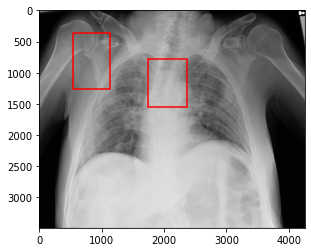

In [60]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
for box in boxes:
    p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                      box['width'], box['height'],
                                      ec='r', fc='none', lw=1.5)
    ax.add_patch(p)
ax.imshow(sample_img, cmap='gray')
plt.show()


## Step 5. Show Multiple Images

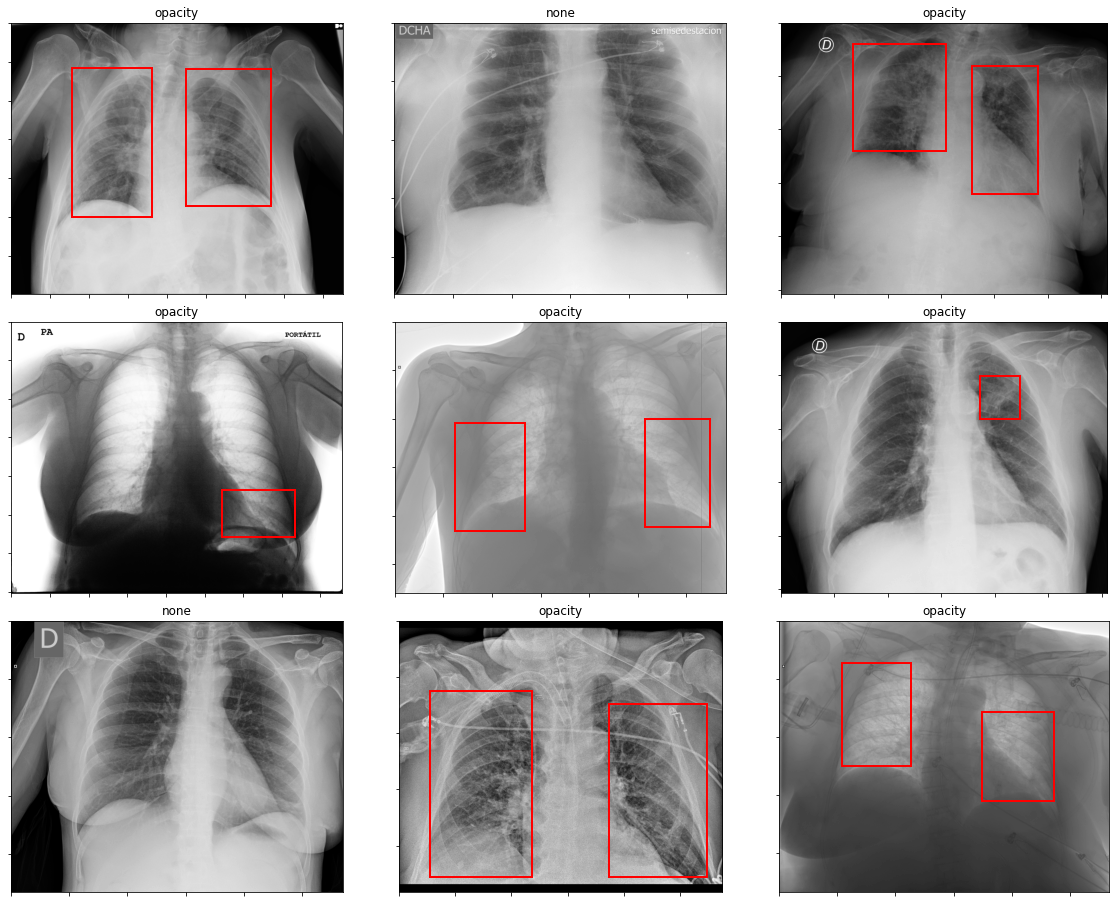

In [21]:
fig, axes = plt.subplots(3,3, figsize=(20,16))
fig.subplots_adjust(hspace=.1, wspace=.1)
axes = axes.ravel()

for row in range(9):
    img = extraction(row)
    # if (nan == nan)
    # False
    if (train_image.loc[row,'boxes'] == train_image.loc[row,'boxes']):
        boxes = ast.literal_eval(train_image.loc[row,'boxes'])
        for box in boxes:
            p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                              box['width'], box['height'],
                                              ec='r', fc='none', lw=2.
                                            )
            axes[row].add_patch(p)
    
    axes[row].imshow(img, cmap='gray')
    axes[row].set_title(train_image.loc[row, 'label'].split(' ')[0])
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])

## Step 6. Feature Engineering

In [22]:
train_image

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e
...,...,...,...,...
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06
6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d


### 6-a. Count Opacity in Image

In [23]:
OpacityCount = train_image['label'].str.count('opacity')
OpacityCount

0       2
1       0
2       2
3       1
4       2
       ..
6329    0
6330    0
6331    3
6332    2
6333    2
Name: label, Length: 6334, dtype: int64

In [24]:
train_image['OpacityCount'] = OpacityCount.values

In [25]:
train_image

,id,boxes,label,StudyInstanceUID,OpacityCount
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,2
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,2
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,1
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,2
...,...,...,...,...,...
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,0
6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e,0
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814,3
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d,2


In [26]:
train_image['id'].isnull().sum()

0

### 6-b. Simplify 'id'

In [27]:
train_image['id'].str.split('_')

0       [000a312787f2, image]
1       [000c3a3f293f, image]
2       [0012ff7358bc, image]
3       [001398f4ff4f, image]
4       [001bd15d1891, image]
                ...          
6329    [ffcc6edd9445, image]
6330    [ffd91a2c4ca0, image]
6331    [ffd9b6cf2961, image]
6332    [ffdc682f7680, image]
6333    [ffe942c8655f, image]
Name: id, Length: 6334, dtype: object

In [28]:
id_extract = lambda x : x[0]

In [29]:
train_image['id'].str.split('_').apply(id_extract)

0       000a312787f2
1       000c3a3f293f
2       0012ff7358bc
3       001398f4ff4f
4       001bd15d1891
            ...     
6329    ffcc6edd9445
6330    ffd91a2c4ca0
6331    ffd9b6cf2961
6332    ffdc682f7680
6333    ffe942c8655f
Name: id, Length: 6334, dtype: object

In [30]:
train_image['id'] = train_image['id'].str.split('_').apply(id_extract)

In [31]:
train_image

,id,boxes,label,StudyInstanceUID,OpacityCount
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,2
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,0
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,2
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,1
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,2
...,...,...,...,...,...
6329,ffcc6edd9445,NaN,none 1 0 0 1 1,7e6c68462e06,0
6330,ffd91a2c4ca0,NaN,none 1 0 0 1 1,8332bdaddb6e,0
6331,ffd9b6cf2961,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814,3
6332,ffdc682f7680,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d,2


In [32]:
train_study

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1
...,...,...,...,...,...
6049,ffcb4630f46f_study,0,1,0,0
6050,ffe4d6e8fbb0_study,0,1,0,0
6051,ffe94fcb14fa_study,0,1,0,0
6052,ffebf1ef4a9c_study,0,1,0,0


In [33]:
train_study['id'].isnull().sum()

0

In [34]:
train_study['id'].str.split('_')

0       [00086460a852, study]
1       [000c9c05fd14, study]
2       [00292f8c37bd, study]
3       [005057b3f880, study]
4       [0051d9b12e72, study]
                ...          
6049    [ffcb4630f46f, study]
6050    [ffe4d6e8fbb0, study]
6051    [ffe94fcb14fa, study]
6052    [ffebf1ef4a9c, study]
6053    [fff649d65f62, study]
Name: id, Length: 6054, dtype: object

In [35]:
train_study['id'].str.split('_').apply(id_extract)

0       00086460a852
1       000c9c05fd14
2       00292f8c37bd
3       005057b3f880
4       0051d9b12e72
            ...     
6049    ffcb4630f46f
6050    ffe4d6e8fbb0
6051    ffe94fcb14fa
6052    ffebf1ef4a9c
6053    fff649d65f62
Name: id, Length: 6054, dtype: object

In [36]:
train_study['id'] = train_study['id'].str.split('_').apply(id_extract)

In [37]:
sum(train_study['id'].str.contains(train_image['StudyInstanceUID'][0]))

1

### 6-c. rename colume 'id' to 'StudyInstanceUID for merge on 'StudyInstanceUID'

In [38]:
train_study = train_study.rename({'id':'StudyInstanceUID'}, axis=1)

In [39]:
train_study

,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852,0,1,0,0
1,000c9c05fd14,0,0,0,1
2,00292f8c37bd,1,0,0,0
3,005057b3f880,1,0,0,0
4,0051d9b12e72,0,0,0,1
...,...,...,...,...,...
6049,ffcb4630f46f,0,1,0,0
6050,ffe4d6e8fbb0,0,1,0,0
6051,ffe94fcb14fa,0,1,0,0
6052,ffebf1ef4a9c,0,1,0,0


In [40]:
train_df = pd.merge(train_image, train_study, on='StudyInstanceUID')
train_df

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,2,0,1,0,0
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,0,1,0,0,0
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,2,0,1,0,0
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,1,0,0,0,1
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,2,0,1,0,0
...,...,...,...,...,...,...,...,...,...
6329,ffcc6edd9445,NaN,none 1 0 0 1 1,7e6c68462e06,0,1,0,0,0
6330,ffd91a2c4ca0,NaN,none 1 0 0 1 1,8332bdaddb6e,0,1,0,0,0
6331,ffd9b6cf2961,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814,3,0,1,0,0
6332,ffdc682f7680,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d,2,0,1,0,0


### 6-d. Check the Relation between 'OpacityCount' and other Columes in train_study

In [41]:
train_df['OpacityCount'].value_counts()

2    3113
0    2040
1     973
3     183
4      23
8       1
5       1
Name: OpacityCount, dtype: int64

In [42]:
train_df.iloc[:,5:].columns

Index(['Negative for Pneumonia', 'Typical Appearance',
       'Indeterminate Appearance', 'Atypical Appearance'],
      dtype='object')

In [43]:
i = 5
for col in train_df.iloc[:,5:].columns:
    print('The Count of {} : '.format(col), sum(train_df.iloc[:,i]))
    i += 1

The Count of Negative for Pneumonia :  1736
The Count of Typical Appearance :  3007
The Count of Indeterminate Appearance :  1108
The Count of Atypical Appearance :  483


In [44]:
train_df[train_df['OpacityCount'] == 0]

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,0,1,0,0,0
6,0023f02ae886,NaN,none 1 0 0 1 1,2fa400b873f5,0,1,0,0,0
22,00c1515729a8,NaN,none 1 0 0 1 1,1a58b43cf286,0,0,1,0,0
25,00e3a7e91a34,NaN,none 1 0 0 1 1,74ba8f2badcb,0,1,0,0,0
26,0d4d6acc9ed3,NaN,none 1 0 0 1 1,74ba8f2badcb,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
6322,ff7659762b75,NaN,none 1 0 0 1 1,4aa11ef1fd38,0,1,0,0,0
6324,ff9f10a24c27,NaN,none 1 0 0 1 1,a937614104e3,0,1,0,0,0
6325,ffa9fef3c7bf,NaN,none 1 0 0 1 1,5133bbb7b75c,0,1,0,0,0
6329,ffcc6edd9445,NaN,none 1 0 0 1 1,7e6c68462e06,0,1,0,0,0


In [45]:
OCount = sorted(list(train_df['OpacityCount'].value_counts().index))
print(OCount)

[0, 1, 2, 3, 4, 5, 8]


In [46]:
for count in OCount:
    print('Opacity Count = {}\n------------------------------'.format(count))
    print(train_df[train_df['OpacityCount'] == count].iloc[:,5:].sum())
    print(' ')

Opacity Count = 0
------------------------------
Negative for Pneumonia      1736
Typical Appearance           153
Indeterminate Appearance      59
Atypical Appearance           92
dtype: int64
 
Opacity Count = 1
------------------------------
Negative for Pneumonia        0
Typical Appearance           27
Indeterminate Appearance    685
Atypical Appearance         261
dtype: int64
 
Opacity Count = 2
------------------------------
Negative for Pneumonia         0
Typical Appearance          2653
Indeterminate Appearance     345
Atypical Appearance          115
dtype: int64
 
Opacity Count = 3
------------------------------
Negative for Pneumonia        0
Typical Appearance          152
Indeterminate Appearance     17
Atypical Appearance          14
dtype: int64
 
Opacity Count = 4
------------------------------
Negative for Pneumonia       0
Typical Appearance          21
Indeterminate Appearance     1
Atypical Appearance          1
dtype: int64
 
Opacity Count = 5
------------------

### 6-e. Visualize the Relation between 'OpacityCount' and other Columes in train_study

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

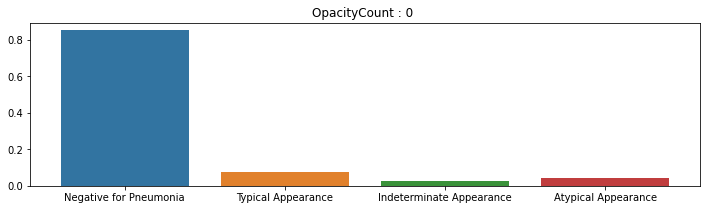

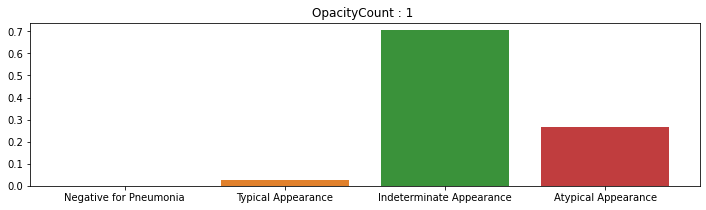

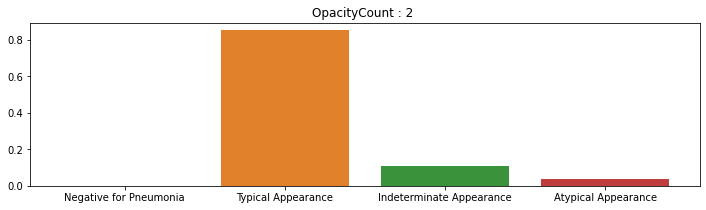

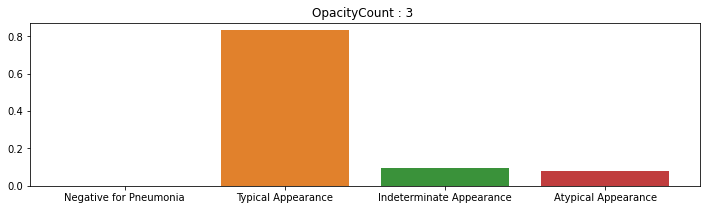

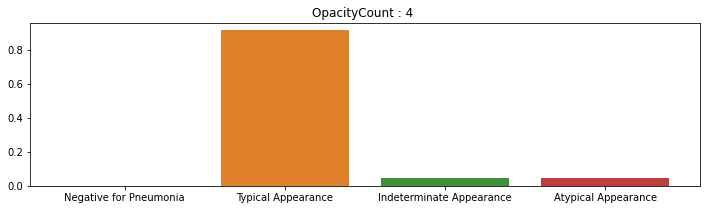

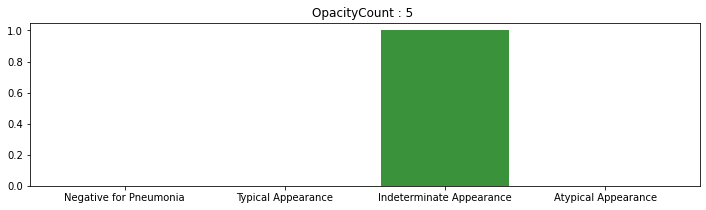

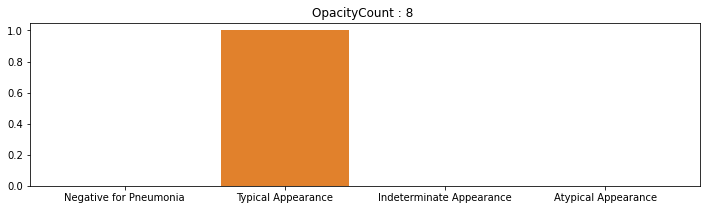

In [48]:
for count in OCount:
    Count_Series = train_df[train_df['OpacityCount'] == count].iloc[:,5:].sum()
    fig = plt.figure(figsize=(12,3))
    sns.barplot(x=Count_Series.index, y=Count_Series.values/sum(train_df['OpacityCount']==count))
    plt.title('OpacityCount : {} '.format(count))
    plt.plot();

### 6-f. Check Duplicate Values(One row and Two Appearances)

In [49]:
sum(train_df['OpacityCount']==1)

973

In [50]:
train_df[(train_df['OpacityCount']==1)&(train_df['Indeterminate Appearance'] == 1)]

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
5,0022227f5adf,"[{'x': 1857.2065, 'y': 508.30565, 'width': 376...",opacity 1 1857.2065 508.30565 2233.23384 907.8...,84543edc24c2,1,0,0,1,0
18,00a129830f4e,"[{'x': 496.23799, 'y': 1175.83357, 'width': 61...",opacity 1 496.23799 1175.83357 1113.61823 1840...,3a3c198051f0,1,0,0,1,0
40,012f57190f1d,"[{'x': 1440.88577, 'y': 1319.0304, 'width': 39...",opacity 1 1440.88577 1319.0304 1838.2981200000...,20eb74deaf29,1,0,0,1,0
43,014a736182d3,"[{'x': 1020.40636, 'y': 1463.8484, 'width': 10...",opacity 1 1020.40636 1463.8484 2091.12218 2373...,a33697e797cc,1,0,0,1,0
45,015169fc4212,"[{'x': 433.38881, 'y': 835.2, 'width': 641.866...",opacity 1 433.38881 835.2 1075.25548 2238.8,528aca245f9a,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...
6295,fe6a2dcda2da,"[{'x': 2128.61914, 'y': 1797.93075, 'width': 5...",opacity 1 2128.61914 1797.93075 2691.894039999...,7902e534869e,1,0,0,1,0
6296,fe6cd1fbae72,"[{'x': 1870.92927, 'y': 1410.89292, 'width': 4...",opacity 1 1870.92927 1410.89292 2311.73481 195...,bf21ae96901c,1,0,0,1,0
6298,fe7fd0793fb3,"[{'x': 723.8129, 'y': 918.02781, 'width': 481....",opacity 1 723.8129 918.02781 1204.824250000000...,07a2358b4e59,1,0,0,1,0
6299,fe829429edc4,"[{'x': 1968.89074, 'y': 1397.96122, 'width': 7...",opacity 1 1968.89074 1397.96122 2762.55224 191...,aa4b16d18061,1,0,0,1,0


In [51]:
train_df[(train_df['OpacityCount']==1)&(train_df['Atypical Appearance'] == 1)]

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,1,0,0,0,1
16,008ca392cff3,"[{'x': 2284.17508, 'y': 1342.64878, 'width': 1...",opacity 1 2284.17508 1342.64878 3307.2952 2708...,39a80a14bfda,1,0,0,0,1
124,0449b62bc0b6,"[{'x': 1738.0842, 'y': 491.24506, 'width': 764...",opacity 1 1738.0842 491.24506 2502.94284 1838....,b66a03d385b2,1,0,0,0,1
155,051c0c15073e,"[{'x': 941.21661, 'y': 677.75974, 'width': 525...",opacity 1 941.21661 677.75974 1466.62181999999...,b65e52a96289,1,0,0,0,1
197,06f4f2f03a93,"[{'x': 1862.59153, 'y': 1748.35, 'width': 593....",opacity 1 1862.59153 1748.35 2456.551529999999...,1073d1b6ddcc,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...
6203,fa9ccef257cf,"[{'x': 1976.45833, 'y': 1439.31252, 'width': 1...",opacity 1 1976.45833 1439.31252 2148.70821 165...,f871e115903e,1,0,0,0,1
6219,fb832b7cf730,"[{'x': 855.37671, 'y': 922.90918, 'width': 340...",opacity 1 855.37671 922.90918 1195.37671 1690....,690a40dcd44c,1,0,0,0,1
6220,fb8e258af5e3,"[{'x': 597.48772, 'y': 1063.96189, 'width': 56...",opacity 1 597.48772 1063.96189 1167.4674 1844....,a27ab5ca843e,1,0,0,0,1
6300,fe94f73e3072,"[{'x': 2887.40002, 'y': 1557.86664, 'width': 1...",opacity 1 2887.40002 1557.86664 3987.40002 231...,9945a45c802e,1,0,0,0,1


In [52]:
train_df[(train_df['OpacityCount']==1)&(train_df['Typical Appearance'] == 1)]

,id,boxes,label,StudyInstanceUID,OpacityCount,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
369,0c65c1436864,"[{'x': 1915.58278, 'y': 633.59996, 'width': 65...",opacity 1 1915.58278 633.59996 2572.43263 1730...,c6e1b0f07d2b,1,0,1,0,0
478,10b1352bfe36,"[{'x': 779.02392, 'y': 1484.38274, 'width': 79...",opacity 1 779.02392 1484.38274 1578.3349600000...,7adea6f20461,1,0,1,0,0
566,13b742f56244,"[{'x': 1594.34016, 'y': 422.96599, 'width': 58...",opacity 1 1594.34016 422.96599 2178.28572 1341...,ce61060be9c9,1,0,1,0,0
603,14fe3a3839c0,"[{'x': 521.29667, 'y': 1306.27967, 'width': 51...",opacity 1 521.29667 1306.27967 1040.22971 2028...,b2b9fffd2865,1,0,1,0,0
711,1a0a148c030f,"[{'x': 900.71579, 'y': 1330.48801, 'width': 61...",opacity 1 900.71579 1330.48801 1517.76468 1982...,49374ea79cdd,1,0,1,0,0
830,1e9fe71f89bf,"[{'x': 589.73334, 'y': 1758.20001, 'width': 10...",opacity 1 589.73334 1758.20001 1597.73334 2914...,48115244cd07,1,0,1,0,0
891,20cde26bb6ff,"[{'x': 625.48512, 'y': 735.50068, 'width': 289...",opacity 1 625.48512 735.50068 915.112320000000...,a567703dcd4c,1,0,1,0,0
1069,27bd4ea4ed28,"[{'x': 236.25646, 'y': 1720.09565, 'width': 81...",opacity 1 236.25646 1720.09565 1052.94544 2099...,a5303f2a4c73,1,0,1,0,0
1319,31b0dc31da93,"[{'x': 1763.60719, 'y': 886.20993, 'width': 80...",opacity 1 1763.60719 886.20993 2572.09534 1810...,29cd2e8cd19c,1,0,1,0,0
1387,33cc8e10ccb0,"[{'x': 829.37512, 'y': 1011.77033, 'width': 37...",opacity 1 829.37512 1011.77033 1205.64111 1645...,9fa2ca50548e,1,0,1,0,0


In [53]:
len(train_df[(train_df['OpacityCount']==1)&(train_df['Indeterminate Appearance'] == 1)]) + len(train_df[(train_df['OpacityCount']==1)&(train_df['Atypical Appearance'] == 1)]) + len(train_df[(train_df['OpacityCount']==1)&(train_df['Typical Appearance'] == 1)])

973

In [54]:
sum(train_df['OpacityCount']==1)

973

In [55]:
sample_submission

,id,PredictionString
0,00188a671292_study,negative 1 0 0 1 1
1,004bd59708be_study,negative 1 0 0 1 1
2,00508faccd39_study,negative 1 0 0 1 1
3,006486aa80b2_study,negative 1 0 0 1 1
4,00655178fdfc_study,negative 1 0 0 1 1
...,...,...
2472,46719b856de1_image,none 1 0 0 1 1
2473,31c07523a69a_image,none 1 0 0 1 1
2474,f77d7d1aebab_image,none 1 0 0 1 1
2475,ccc5b63ca96d_image,none 1 0 0 1 1
